## Setup

In [1]:
import sys
sys.path.append('../')
del sys
%reload_ext autoreload
%autoreload 2

In [2]:
from modeling.pipeline import Pipeline
from modeling.utils import ap_at_k, ndcg
from modeling.nn import MLP

import torch
from numpy import mean
import matplotlib.pyplot as plt

## Parameters

In [3]:
batch_size = 32
drop_last = True
test_proportion = 0.25
valid_proportion = 0.25
use_k_fold = False
k_k_fold = None

## Metrics

In [4]:
loss = torch.nn.MSELoss()
score = ap_at_k
k_score = 10

## Load the data

In [5]:
pipeline = Pipeline(use_k_fold=use_k_fold)
pipeline.process_data(batch_size=batch_size,
                      drop_last=drop_last,
                      test_proportion=test_proportion,
                      valid_proportion=valid_proportion,
                      k=k_k_fold)

Processing the modeling task...
Computing the annotated queries...
Initial length of queries: 0
Object loaded from ../results/../results/task_annotation/v2_0/task/queries_size10k_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_1/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Object loaded from ../results/../results/task_annotation/v2_2/task/queries_sizemax_shuffle_articles1_queries1_seed0.pkl
Final length of queries: 61056
Done (elapsed time: 1s).

Computing the annotations...
Initial length of annotations: 0
Object loaded from ../results/task_annotation/v2_0/results/batch_00_complete.csv
   Correcting "n this article, Nevada and Ohio are discussed. The two American states..." to " The two American states..."
   Correcting "In this article, California and Oregon are discussed. The two neighboring states..." to " The two neighboring states..."
   Correcting "In this article, California and Oregon are discussed. The two West Coa

## Baselines

In [6]:
from modeling.models import RandomBaseline

model = RandomBaseline(loss=loss, score=score, k=k_score)
pipeline.preview_data(model)
train_losses, valid_losses, valid_scores = pipeline.train_model(model)
print("Mean Train losses: %.3f Valid loss: %.3f Valid scores: %.3f" 
      % (mean(train_losses), mean(valid_losses), mean(valid_scores)))

Training of the model...




Epoch 1/1: Validation Loss: 0.335 Validation Score: 0.008
--------------------------------------------------------------
Mean Train losses: 0.333 Valid loss: 0.335 Valid scores: 0.008


In [7]:
from modeling.models import CountsBaseline

model = CountsBaseline(loss=loss, score=score, k=k_score)
pipeline.preview_data(model)
train_losses, valid_losses, valid_scores = pipeline.train_model(model)
print("Mean Train losses: %.3f Valid loss: %.3f Valid scores: %.3f" 
      % (mean(train_losses), mean(valid_losses), mean(valid_scores)))

Learning answers counts...



Training of the model...




Epoch 1/1: Validation Loss: 0.007 Validation Score: 0.326
--------------------------------------------------------------
Mean Train losses: 0.076 Valid loss: 0.007 Valid scores: 0.326


In [8]:
from modeling.models import SummariesCountBaseline

model = SummariesCountBaseline(loss=loss, score=score, k=k_score)
pipeline.preview_data(model)
train_losses, valid_losses, valid_scores = pipeline.train_model(model)
print("Mean Train losses: %.3f Valid loss: %.3f Valid scores: %.3f" 
      % (mean(train_losses), mean(valid_losses), mean(valid_scores)))

Training of the model...




Epoch 1/1: Validation Loss: 0.032 Validation Score: 0.112
--------------------------------------------------------------
Mean Train losses: 0.092 Valid loss: 0.032 Valid scores: 0.112


In [9]:
from modeling.models import SummariesOverlapBaseline

model = SummariesOverlapBaseline()
pipeline.preview_data(model)
train_losses, valid_losses, valid_scores = pipeline.train_model(model)
print("Mean Train losses: %.3f Valid loss: %.3f Valid scores: %.3f" 
      % (mean(train_losses), mean(valid_losses), mean(valid_scores)))

Training of the model...




Epoch 1/1: Validation Loss: 0.043 Validation Score: 0.064
--------------------------------------------------------------
Mean Train losses: 0.112 Valid loss: 0.043 Valid scores: 0.064


## Models

In [6]:
from modeling.models import BOWModel

model = BOWModel(min_vocab_frequency=100, net=None, optimizer=None, loss=loss, score=score, k=k_score)
pipeline.preview_data(model)

Learning the vocabulary...



Input size: 5505


In [7]:
model.net = MLP(input_dim=5505,
                hidden_dim=500,
                output_dim=1,
                dropout=0.1)
model.optimizer = torch.optim.Adam(model.net.parameters(),
                                   lr=1e-4)

In [8]:
train_losses, valid_losses, valid_scores = pipeline.train_model(model, n_epochs=1)
print("Mean Train losses: %.3f Valid loss: %.3f Valid scores: %.3f" 
      % (mean(train_losses), mean(valid_losses), mean(valid_scores)))

Training of the model...




Epoch 1/1: Validation Loss: 0.004 Validation Score: 0.320
--------------------------------------------------------------
Mean Train losses: 0.005 Valid loss: 0.004 Valid scores: 0.320


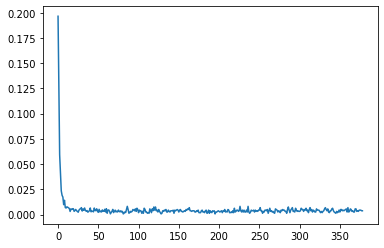

In [9]:
plt.yscale('log')
plt.plot(range(len(train_losses)), train_losses)

In [10]:
from modeling.models import EmbeddingModel

model = EmbeddingModel(net=None, optimizer=None, loss=loss, score=score, k=k_score)
pipeline.preview_data(model)

Initializing the Word2Vec embedding...
Initializing the FreeBase embedding...
Input dimension: 1600


In [11]:
model.net = MLP(input_dim=1600,
                hidden_dim=500,
                output_dim=1,
                dropout=0.1)
model.optimizer = torch.optim.Adam(model.net.parameters(),
                                   lr=1e-4)

In [12]:
train_losses, valid_losses, valid_scores = pipeline.train_model(model, n_epochs=1)
print("Mean Train losses: %.3f Valid loss: %.3f Valid scores: %.3f" 
      % (mean(train_losses), mean(valid_losses), mean(valid_scores)))

Training of the model...




Epoch 1/1: Validation Loss: 0.004 Validation Score: 0.139
--------------------------------------------------------------
Mean Train losses: 0.004 Valid loss: 0.004 Valid scores: 0.139


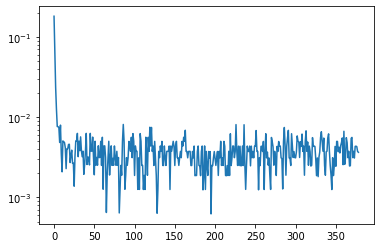

In [14]:
plt.yscale('log')
plt.plot(range(len(train_losses)), train_losses)

### Observe the task

In [4]:
cmpt = 0
for data in pipeline.raw_data:
    if cmpt == 0:
        print("Length of the choices: {}".format(len(data[0]['choices'])), '\n')
    
    print("Entities:", ', '.join(data[0]['entities']))
    print("Choices:", ', '.join(data[0]['choices'][:10]) + ',...')
    print('Good answers:',', '.join([data[0]['choices'][i] for i in range(len(data[0]['choices'])) if data[1][i]]))
    print('Contexts:', data[0]['context'])
    print('Summaries:', ' '.join(data[0]['summaries']))
    print()
    cmpt += 1
    if cmpt == 10:
        break
    

Length of the choices: 954 

Entities: Jennifer Kaufman, Karen Mack
Choices: former enron employees, cabinet members, american statesmen, men with religious backgrounds, movie makers, agents, felons, celebrated writers, friends, nepalese politicians,...
Good answers: co-author, authors
Contexts: Chick Lit That Mixes Voltaire With Vogue: Literacy and Longing in L.A. By Jennifer Kaufman and Karen Mack 325 pages. Delacorte.
Summaries: No information found. Karen Mack is an American television producer for CBS and co-author of three novels from Los Angeles, California.

Entities: Charlie McDermott, Kris Kristofferson
Choices: pennsylvania leaders, contributors to the film, business partners, former presidential candidates, american democratic politicians, people in power, reporter icons, american former professional basketball players, home buyers, pixar executives,...
Good answers: entertainers, actors
Contexts: Realism, Both Magic and Downright Mean: The biggest gaffe is the discordant p

In [26]:
from modeling.utils import ap
import torch
t1 = torch.tensor([[1, 2], [3, 4]])
t2 = torch.tensor([[2, 1], [4, 2]])
ap(t1, t2)

2 2
tensor([[3],
        [6]])


Exception: 

In [10]:
from modeling.models import EmbeddingModel

In [11]:
model = EmbeddingModel()

In [12]:
model.word2vec_embedding()

AttributeError: 'EmbeddingModel' object has no attribute 'word2vec_embedding'

NameError: name 'model' is not defined

In [16]:
import torch
torch.tensor(model.general_embedding['the']).type()

[autoreload of modeling.models failed: Traceback (most recent call last):
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 724, in exec_module
  File "<frozen importlib._bootstrap_external>", line 860, in get_code
  File "<frozen importlib._bootstrap_external>", line 791, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call

'torch.FloatTensor'

In [13]:
model.freebase_embedding()

In [33]:
model.entity_embedding.get_vector('/en/barack_obama').shape

[autoreload of modeling.models failed: Traceback (most recent call last):
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/clement/miniconda3/envs/nlp/lib/python3.7/site-packages/IPython/extensions/autoreload.py"

(1000,)

In [34]:
model.entity_embedding.vocab

{'/en/united_states': <gensim.models.keyedvectors.Vocab at 0x1b4a42d210>,
 '/en/associated_press': <gensim.models.keyedvectors.Vocab at 0x1b4a42d490>,
 '/en/barack_obama': <gensim.models.keyedvectors.Vocab at 0x1077f5f50>,
 '/en/china': <gensim.models.keyedvectors.Vocab at 0x1b4a4204d0>,
 '/en/united_kingdom': <gensim.models.keyedvectors.Vocab at 0x1b4a420890>,
 '/en/new_york': <gensim.models.keyedvectors.Vocab at 0x1b4a420bd0>,
 '/en/india': <gensim.models.keyedvectors.Vocab at 0x1b4a420b90>,
 '/en/europe': <gensim.models.keyedvectors.Vocab at 0x1b4a439210>,
 '/en/washington_united_states': <gensim.models.keyedvectors.Vocab at 0x1b4a4391d0>,
 '/en/canada': <gensim.models.keyedvectors.Vocab at 0x1b4a439150>,
 '/en/iraq': <gensim.models.keyedvectors.Vocab at 0x1b4a439190>,
 '/en/israel': <gensim.models.keyedvectors.Vocab at 0x1b4a4390d0>,
 '/en/california': <gensim.models.keyedvectors.Vocab at 0x1b4a439ad0>,
 '/en/republican_party': <gensim.models.keyedvectors.Vocab at 0x1b4a439b90>,
 '